In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
import cv2, os
from os import listdir
from os.path import isfile, join
import scipy

import preprocess
from nvi_utils import random_shadow, random_brightness

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

#from ironcar import Ironcar

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten

def build_model():                                                              
    """                                                                         
    Modified NVIDIA model                                                       
    """                                                                         
    model = Sequential()                                                        
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))           
    model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))             
    model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))             
    model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))             
    model.add(Conv2D(64, 3, 3, activation='elu'))                               
    model.add(Conv2D(64, 3, 3, activation='elu'))                               
    model.add(Dropout(0.5))                                                     
    model.add(Flatten())                                                        
    model.add(Dense(100, activation='elu'))                                     
    model.add(Dense(50, activation='elu'))                                      
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))                                                      

    return model 

In [3]:
#ironcar = Ironcar()
root = "../AutoCar/records_good/"

files = [f for f in listdir(root) if isfile(join(root, f))]

for f in files:
    try:
        file_path = root + f
        img = cv2.imread(file_path)
        #img = img[img.shape[0] - IMAGE_HEIGHT + 1:, :, :]
        cv2.imwrite("./normal/" + f, img)

    except ValueError:
        print(root + f)


In [7]:
def resize(img):
    img = img[60:-20]
    return scipy.misc.imresize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))

/home/cai/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="elu")`
  # Remove the CWD from sys.path while we load stuff.
/home/cai/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="elu")`
  # This is added back by InteractiveShellApp.init_path()
/home/cai/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="elu")`
  if sys.path[0] == '':
/home/cai/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  del sys.path[0]
/home/cai/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras

array([[-1.6915566],
       [-1.7131447]], dtype=float32)

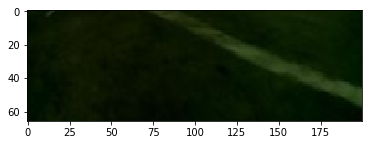

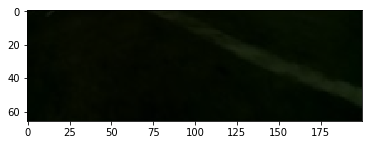

In [33]:
model_name = "./models/model-0,5YUV.h5"
model = build_model()
model.load_weights(model_name)

img = cv2.imread("./normal/frame_2434_gas_0.4_dir_-1.3.jpg")
img = resize(img)
# replace random_shadow by random_brightness to test brightness
shadow = random_shadow(img)

import matplotlib.pyplot as plt

# RGB TO BGR for plt
img_disp = img[:, :, ::-1]
shadow_disp = shadow[:, :, ::-1]
plt.imshow(img_disp)
plt.figure()
plt.imshow(shadow_disp)

model.predict(np.array([preprocess.rgb2yuv(img), preprocess.rgb2yuv(shadow)]))

In [10]:
model_name = "./models/model-0,0YUV.h5"
model = build_model()
model.load_weights(model_name)

funs = [(lambda x: x), random_shadow, random_brightness]
root = "./normal/"
res = []

for fun, i in zip(funs, range(len(funs))):
    files = [root + f for f in listdir(root) if isfile(join(root, f))]
    imgs = [ img for img in map(cv2.imread, files) ]
    imgs = [ img for img, _ in map(preprocess.preprocess, imgs)]
    imgs = [ img for img in map(fun, imgs)]
    
    prediction = model.predict(np.array(imgs))
    res.append(prediction)
    
print("shadow")
diff = abs(res[0] - res[1])
mean = np.mean(diff)
print(mean)

df = pd.DataFrame(diff, index=['Row'+str(i) for i in range(len(diff))])
print(df.describe())

print("light")
diff2 = abs(res[0] - res[2])
mean2 = np.mean(diff2)
print(mean2)

df2 = pd.DataFrame(diff2, index=['Row'+str(i) for i in range(len(diff2))])
print(df2.describe())

"""
for f in files:
    file_path = root + f
    img = cv2.imread(file_path)
    img = np.array([img])
    prediction.append(model.predict(img))


root = "./blur/"
files = [f for f in listdir(root) if isfile(join(root, f))]
blur_pred = []

for f in files:
    file_path = root + f
    img = mpimg.imread(file_path)
    img = np.array([img])
    blur_pred.append(model.predict(img))

print(np.array(prediction))
#print(np.array(blur_pred))
"""

/home/cai/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="elu")`
  # Remove the CWD from sys.path while we load stuff.
/home/cai/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="elu")`
  # This is added back by InteractiveShellApp.init_path()
/home/cai/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="elu")`
  if sys.path[0] == '':
/home/cai/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  del sys.path[0]
/home/cai/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras

shadow
0.5272702
                 0
count  3996.000000
mean      0.527270
std       0.495066
min       0.000136
25%       0.088558
50%       0.355204
75%       0.909329
max       2.159328
light
0.506538
                 0
count  3996.000000
mean      0.506538
std       0.408749
min       0.000000
25%       0.151419
50%       0.396839
75%       0.826950
max       1.906601


'\nfor f in files:\n    file_path = root + f\n    img = cv2.imread(file_path)\n    img = np.array([img])\n    prediction.append(model.predict(img))\n\n\nroot = "./blur/"\nfiles = [f for f in listdir(root) if isfile(join(root, f))]\nblur_pred = []\n\nfor f in files:\n    file_path = root + f\n    img = mpimg.imread(file_path)\n    img = np.array([img])\n    blur_pred.append(model.predict(img))\n\nprint(np.array(prediction))\n#print(np.array(blur_pred))\n'

In [11]:
print(df.idxmax())
print(files[430])

print(df2.idxmax())
print(files[815])

0    Row3010
dtype: object
./normal/frame_2432_gas_0.4_dir_-1.3.jpg
0    Row1038
dtype: object
./normal/frame_2434_gas_0.4_dir_-1.3.jpg
